# ProtTans Finetuning with LoRA for Signal Peptide Prediction

## Links
### Papers/ Knowledge
- https://www.sciencedirect.com/science/article/pii/S2001037021000945
- https://huggingface.co/blog/peft
- https://ieeexplore.ieee.org/ielx7/34/9893033/9477085/supp1-3095381.pdf?arnumber=9477085
### Architecture
- https://www.philschmid.de/fine-tune-flan-t5-peft
- https://huggingface.co/spaces/evaluate-metric/seqeval
- https://huggingface.co/docs/transformers/v4.33.3/en/model_doc/esm#transformers.EsmForTokenClassification
- https://huggingface.co/docs/datasets/v2.14.5/en/package_reference/builder_classes#datasets.SplitGenerator
- https://huggingface.co/docs/datasets/v2.14.5/en/package_reference/main_classes#datasets.Dataset.add_column
- https://huggingface.co/docs/transformers/main_classes/data_collator
- https://huggingface.co/docs/transformers/main/en/main_classes/trainer#checkpoints
### Code
- https://github.com/ziegler-ingo/cleavage_extended/blob/master/models/final/c_bilstm_t5_coteaching.ipynb
- https://www.kaggle.com/code/henriupton/proteinet-pytorch-ems2-t5-protbert-embeddings/notebook#7.-Train-the-Model
- https://www.kaggle.com/code/prithvijaunjale/t5-multi-label-classification
### Optmization
- https://huggingface.co/blog/accelerate-large-models
- https://huggingface.co/docs/transformers/hpo_train

## ToDo
- Implement BitsAndBites (QLoRA)
- Implement DeepSpeed
- Fix weird extra char on inference

## Notebook Setup
___

In [1]:
%load_ext autoreload
%autoreload 2

## Packages
___

In [2]:
import re
import gc
import os
import math
import copy
import types
import yaml
import sys

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import (
    CrossEntropyLoss,
    MSELoss
)
from torch.utils.data import DataLoader

import evaluate

import transformers
from transformers import (
    AutoModelForTokenClassification,
    AutoConfig,
    T5EncoderModel,
    T5Tokenizer,
    T5PreTrainedModel,
    T5ForConditionalGeneration,
    pipeline,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    set_seed,
    EvalPrediction,
    )
from transformers.modeling_outputs import TokenClassifierOutput

from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    get_peft_config,
    PeftModel,
    PeftConfig,
    prepare_model_for_kbit_training
    )

from datasets import Dataset

import src.config as config

from src.model import (
    get_prottrans_tokenizer_model,
    df_to_dataset,
    inject_linear_layer,
    compute_metrics_fast
    )
from src.utils import get_project_root_path

---
## Setup and Variables

In [3]:
base_model_name = config.base_model_name
print("Base Model:\t", base_model_name)
print("MPS:\t\t", torch.backends.mps.is_available())
ROOT = get_project_root_path()
print("Path:\t\t", ROOT)
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(f"Using device:\t {device}")

Base Model:	 Rostlab/prot_t5_xl_uniref50
MPS:		 False
Path:		 /home/ec2-user/developer/prottrans-t5-signalpeptide-prediction
Using device:	 cuda:0


In [4]:
pd.set_option('display.max_colwidth',3000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

---
## Create Tokenizer and Load Model

In [5]:
# model_architecture = T5ForConditionalGeneration
model_architecture = T5EncoderModel
t5_tokenizer, t5_base_model = get_prottrans_tokenizer_model(base_model_name, model_architecture)

---
## Load Data, Split into Dataset, and Tokenize Sequences

In [6]:
df_data = pd.read_parquet(ROOT + '/data/processed/5.0_train.parquet.gzip')

In [7]:
df_data.head()

,Sequence,Label,Split
0,M A P T L F Q K L F S K R T G L G A P G R D A R D P D C G F S W P L P E F D P S Q I R L I V Y Q D C E R R G R N V L F D S S V K R R N E D I,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
1,M D F T S L E T T T F E E V V I A L G S N V G N R M N N F K E A L R L M K D Y G I S V T R H S C L Y E T E P V H V T D Q P R F L N A A I R G,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1
2,M D D I S G R Q T L P R I N R L L E H V G N P Q D S L S I L H I A G T N G K E T V S K F L T S I L Q H P G Q Q R Q R V L I G R Y T T S S L L,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1
3,M L G T V K M E G H E T S D W N S Y Y A D T Q E A Y S S V P V S N M N S G L G S M N S M N T Y M T M N T M T T S G N M T P A S F N M S Y A N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4
4,M L G A V K M E G H E P S D W S S Y Y A E P E G Y S S V S N M N A G L G M N G M N T Y M S M S A A A M G G G S G N M S A G S M N M S S Y V G,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4


In [8]:
ds_train = df_data[df_data.Split.isin([0, 1, 2])].head(config.dataset_size*3)
ds_train = df_to_dataset(
    t5_tokenizer,
    ds_train.Sequence.to_list(),
    ds_train.Label.to_list(),
)

ds_validate = df_data[df_data.Split.isin([3])].head(config.dataset_size)
ds_validate = df_to_dataset(
    t5_tokenizer,
    ds_validate.Sequence.to_list(),
    ds_validate.Label.to_list(),
)

ds_test = df_data[df_data.Split.isin([4])].head(config.dataset_size)
ds_test = df_to_dataset(
    t5_tokenizer,
    ds_test.Sequence.to_list(),
    ds_test.Label.to_list()
)

In [9]:
del df_data

In [10]:
print(ds_train)
print(ds_validate)
print(ds_test)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12459
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 4148
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 4146
})


In [11]:
print(ds_test[0]['input_ids'])
print(len(ds_test[0]['input_ids']))
print(ds_test[0]['attention_mask'])
print(len(ds_test[0]['attention_mask']))
print(ds_test[0]['labels'])
print(len(ds_test[0]['labels']))

[19, 4, 5, 11, 6, 14, 19, 9, 5, 20, 9, 11, 7, 10, 21, 17, 7, 18, 18, 3, 10, 11, 16, 9, 3, 18, 7, 7, 6, 13, 6, 7, 17, 19, 17, 7, 5, 4, 5, 7, 19, 17, 7, 19, 17, 11, 18, 19, 11, 19, 17, 11, 19, 11, 11, 7, 5, 17, 19, 11, 13, 3, 7, 15, 17, 19, 7, 18, 3, 17, 1]
71
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
71
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
70


In [12]:
t5_tokenizer.decode(ds_test[0]['input_ids'])

'M L G T V K M E G H E T S D W N S Y Y A D T Q E A Y S S V P V S N M N S G L G S M N S M N T Y M T M N T M T T S G N M T P A S F N M S Y A N</s>'

In [13]:
t5_tokenizer.decode(range(0, 28))

'<pad></s><unk>A L G V S R E D T I P K F Q N Y M H W C X B O U Z'

---
## Apply LoRA

In [14]:
lora_config = LoraConfig(
        # task_type=TaskType.TOKEN_CLS,
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.05,
        target_modules=['q', 'k', 'v', 'o'],
        # target_modules=['o'],
        bias="none",
    )

In [15]:
t5_lora_model = get_peft_model(t5_base_model, lora_config)
# del t5_base_model
# t5_lora_model = prepare_model_for_kbit_training(t5_lora_model) # add quantization
# t5_lora_model = t5_base_model

In [16]:
t5_lora_model.print_trainable_parameters()

trainable params: 3,932,160 || all params: 1,212,073,984 || trainable%: 0.32441584027926795


In [17]:
t5_lora_model.get_base_model().forward

<bound method T5EncoderModel.forward of T5EncoderModel(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(
                in_features=1024, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k): Linear(
                in_features=1024, out_features=4096, bias=F

---
## DeepSpeed

In [18]:
# os.environ["MASTER_ADDR"] = "127.0.0.1"
# os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
# os.environ["RANK"] = "0"
# os.environ["LOCAL_RANK"] = "0"
# os.environ["WORLD_SIZE"] = "1"

In [19]:
# with open(ROOT+'/deepspeed_config.yaml', 'r') as file:
#     deepspeed_config = yaml.safe_load(file)
#     del file

In [20]:
# deepspeed_config = {
#     "fp16": {
#         "enabled": "auto",
#         "loss_scale": 0,
#         "loss_scale_window": 1000,
#         "initial_scale_power": 16,
#         "hysteresis": 2,
#         "min_loss_scale": 1
#     },

#     "optimizer": {
#         "type": "AdamW",
#         "params": {
#             "lr": "auto",
#             "betas": "auto",
#             "eps": "auto",
#             "weight_decay": "auto"
#         }
#     },

#     "scheduler": {
#         "type": "WarmupLR",
#         "params": {
#             "warmup_min_lr": "auto",
#             "warmup_max_lr": "auto",
#             "warmup_num_steps": "auto"
#         }
#     },

#     "zero_optimization": {
#         "stage": 2,
#         "offload_optimizer": {
#             "device": "cpu",
#             "pin_memory": True
#         },
#         "allgather_partitions": True,
#         "allgather_bucket_size": 2e8,
#         "overlap_comm": True,
#         "reduce_scatter": True,
#         "reduce_bucket_size": 2e8,
#         "contiguous_gradients": True
#     },

#     "gradient_accumulation_steps": "auto",
#     "gradient_clipping": "auto",
#     "steps_per_print": 2000,
#     "train_batch_size": "auto",
#     "train_micro_batch_size_per_gpu": "auto",
#     "wall_clock_breakdown": False
# }

---
## Training Loop
https://huggingface.co/docs/peft/task_guides/token-classification-lora

In [21]:
data_collator = DataCollatorForTokenClassification(tokenizer=t5_tokenizer)

In [22]:
t5_lora_model = inject_linear_layer(
    t5_lora_model=t5_lora_model,
    num_labels=config.label_decoding.__len__(),
    dropout_rate=config.dropout_rate
    )

In [23]:
t5_lora_model.get_base_model().forward

<bound method T5EncoderModel.forward of T5EncoderModel(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(
                in_features=1024, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k): Linear(
                in_features=1024, out_features=4096, bias=F

In [24]:
metric = evaluate.load("glue", "mrpc")
def compute_metrics_custom(eval_preds: EvalPrediction):
    print(*eval_preds)
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [25]:
training_args = TrainingArguments(
    output_dir='./checkpoints',
    learning_rate=config.lr,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.num_epochs,
    logging_steps=config.logging_steps,
    # save_strategy="steps",
    save_steps=config.save_steps,
    # evaluation_strategy="steps",
    # eval_steps=config.eval_steps,
    # load_best_model_at_end=True,
    # save_total_limit=5,
    seed=42,
    # fp16=True,
    # deepspeed=deepspeed_config
)

trainer = Trainer(
    model=t5_lora_model,
    args=training_args,
    train_dataset=ds_train,
    # eval_dataset=ds_validate,
    data_collator=data_collator,
    compute_metrics=config.metric
)

In [26]:
# ([set(x) for x in ds_validate['labels']])

In [27]:
# ds_validate['labels'][
#     [set(x) for x in ds_validate['labels']] != {0}
#     ]

In [28]:
print(next(t5_lora_model.parameters()).is_cuda)
print(t5_lora_model.device)
print(config.label_decoding)

True
cuda:0
{0: 'I', 1: 'L', 2: 'M', 3: 'O', 4: 'S', 5: 'T'}


In [29]:
gc.collect()
torch.cuda.empty_cache()

In [30]:
trainer.train()

Step,Training Loss
20,1.139800
40,0.310100
60,0.190800
80,0.177600
100,0.128900
120,0.130000
140,0.112100
160,0.153300
180,0.110000
200,0.077700


TrainOutput(global_step=779, training_loss=0.13150859598323836, metrics={'train_runtime': 1132.2796, 'train_samples_per_second': 11.003, 'train_steps_per_second': 0.688, 'total_flos': 6432455417918292.0, 'train_loss': 0.13150859598323836, 'epoch': 1.0})

In [ ]:
# metrics=trainer.evaluate()
# print(metrics)

---

In [69]:
ds_validate['labels'][9].__len__()

59

In [81]:
print(ds_validate)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 4148
})


In [84]:
target = torch.zeros(4148,70)
target.shape

torch.Size([4148, 70])

In [111]:
# [x + [-1] * (70-len(x)) for x in ds_validate['labels']]

In [144]:
# inlab = torch.tensor([x + [-1] * (70-len(x)) for x in ds_validate['labels']]).to('cpu')
# inlab.shape

In [145]:
del inlab

In [115]:
inid = torch.tensor(ds_validate['input_ids']).to(device)
inid.shape

torch.Size([4148, 71])

In [170]:
gc.collect()
torch.cuda.empty_cache()

In [152]:
predictions = t5_lora_model(input_ids=inid[0:1])

In [205]:
import tqdm

In [239]:
results = []
for index, _ in enumerate(inid):
    if index % 100 == 0:
        torch.cuda.empty_cache()
    results += t5_lora_model(input_ids=inid[index:index+1]).logits.argmax(dim=-1).tolist()

In [240]:
len(results)

4148

In [221]:
correct_labels = [[config.label_decoding[y] for y in x] for x in ds_validate['labels']]

In [241]:
len(correct_labels)

4148

In [242]:
correct = 0
incorrect = 0

for index, item in enumerate(results):
    truth = correct_labels[index]
    prediction = [config.label_decoding[x] for x in item[:len(correct_labels[index])]]
    
    for t, p in zip(truth, prediction):
        if t == p:
            correct += 1
        else:
            incorrect += 1
    
    # print(*truth, sep='')
    # print(*prediction, sep='')
    # print()
    
print("Correct", correct)
print("Incorrect", incorrect)

Correct 283592
Incorrect 6200


In [243]:
print(correct/(correct+incorrect))

0.9786053445229682


In [ ]:
# print(*prediction[0].argmax(dim=-1)[0].tolist())

In [ ]:
# print(*[config.label_decoding[x] for x in prediction[0].argmax(dim=-1)[0].tolist()])

In [ ]:
# print(prediction[0].argmax(dim=-1))
# print(inlab)
# print(inlab == prediction[0].argmax(dim=-1)[:, :70])

In [ ]:
# cust_pred = EvalPrediction(prediction, inlab)

In [ ]:
# print(*cust_pred)

In [ ]:
# compute_metrics_custom(cust_pred)

---
## Results

In [32]:
result_log = pd.DataFrame(trainer.state.log_history)

In [33]:
display(result_log)

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.1398,0.000974,0.03,20,NaN,NaN,NaN,NaN,NaN
1,0.3101,0.000949,0.05,40,NaN,NaN,NaN,NaN,NaN
2,0.1908,0.000923,0.08,60,NaN,NaN,NaN,NaN,NaN
3,0.1776,0.000897,0.10,80,NaN,NaN,NaN,NaN,NaN
4,0.1289,0.000872,0.13,100,NaN,NaN,NaN,NaN,NaN
5,0.1300,0.000846,0.15,120,NaN,NaN,NaN,NaN,NaN
6,0.1121,0.000820,0.18,140,NaN,NaN,NaN,NaN,NaN
7,0.1533,0.000795,0.21,160,NaN,NaN,NaN,NaN,NaN
8,0.1100,0.000769,0.23,180,NaN,NaN,NaN,NaN,NaN
9,0.0777,0.000743,0.26,200,NaN,NaN,NaN,NaN,NaN


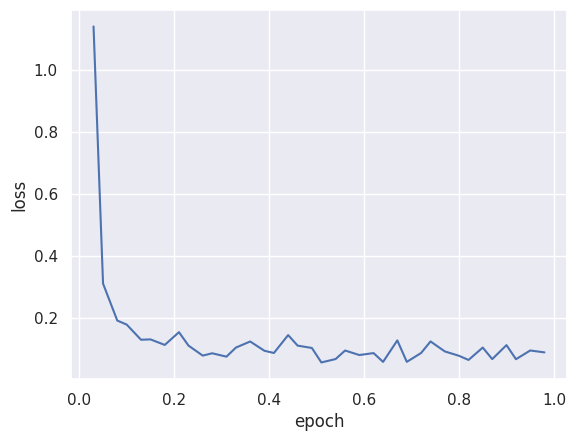

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
my_plot = sns.lineplot(data=result_log, x='epoch', y='loss')

In [52]:
fig = my_plot.get_figure()
fig.savefig("./plots/out.png") 

---
## Save Model

In [127]:
t5_lora_model.save_pretrained(ROOT + '/models/linear_model_v3')

---
---
---

---
## Save Trainer

Q02742|EUKARYA|NO_SP|4\
MLRTLLRRRLFSYPTKYYFMVLVLSLITFSVLRIHQKPEFVSVRHLELAGENPSSDINCTKVLQGDVNEI\
IIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

Q9NQR9|EUKARYA|NO_SP|4\
MDFLHRNGVLIIQHLQKDYRAYYTFLNFMSNVGDPRNIFFIYFPLCFQFNQTVGTKMIWVAVIGDWLNLI\
OOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIIMMMMMMMMMMMMMM

In [ ]:
print(*ds_test[1])

In [ ]:
t5_lora_model.to(device)

test_set = ds_test.select(range(0,2)).with_format("torch", device=device)

# For token classification we need a data collator here to pad correctly
data_collator = DataCollatorForTokenClassification(t5_tokenizer) 

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle = False, collate_fn = data_collator)

# Put the model in evaluation mode
t5_lora_model.eval()

# Make predictions on the test dataset
predictions = []
# We need to collect the batch["labels"] as well, this allows us to filter out all positions with a -100 afterwards
padded_labels = []

counter = 0

In [ ]:
with torch.no_grad():
    for batch in test_dataloader:
        # print(counter)
        counter += 1
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Padded labels from the data collator
        padded_labels += batch['labels'].tolist()
        print(padded_labels)
        # Add batch results(logits) to predictions, we take the argmax here to get the predicted class
        print(input_ids)
        prediction = t5_lora_model(input_ids=input_ids).logits.argmax(dim=-1).tolist()
        print(prediction)
        predictions += prediction#.argmax(dim=-1).tolist()

In [ ]:
index_item = 1

actual = [config.label_decoding[x] for x in test_set['labels'][index_item].tolist()]
print(actual.__len__())
print(*actual)

pred = [config.label_decoding[x] for x in predictions[index_item]]
print(pred.__len__())
print(*pred)